Total revenue with dynamic pricing: ₹481755.00
Total revenue with fixed pricing: ₹387086.18
Percentage of lost customers due to parking full: 0.00%
Total number of arrivals: 15519.0
Average parking space utilization from 8:00 to 11:59: 16.15%
Average parking space utilization from 12:00 to 16:59: 21.80%
Average parking space utilization from 17:00 to 19:59: 27.51%


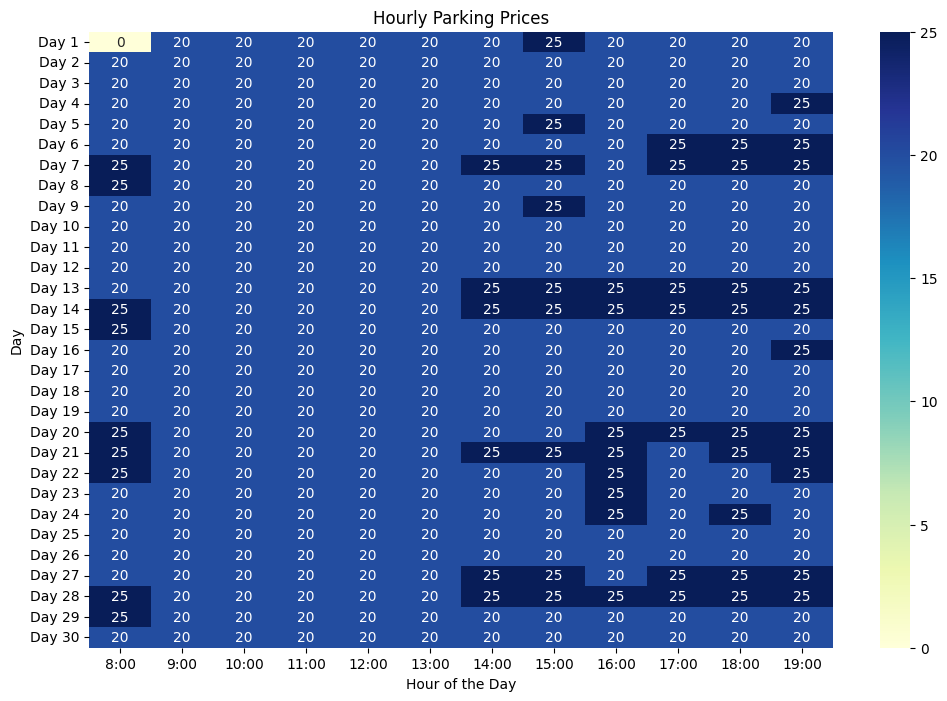

In [49]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulation parameters
SIM_DURATION = 30 * 12 * 60  # 30 days, 12 hours per day (8 AM to 8 PM)
CAPACITY = 200
BASE_PRICE = 25
FIXED_PRICE = 25
price_history = []  # List to track price changes over time
wtv_history = np.zeros((30, 12))  # WTV history for each hour and day
INITIAL_WILLINGNESS_TO_VISIT=0.8
# Arrival rates based on the day of the week and time slots
ARRIVAL_RATES = {
    'Sunday': [(8, 12, 15*1), (12, 17, 50*1), (17, 20, 50*1)],
    'Monday': [(8, 12, 15*1), (12, 17, 50*1), (17, 20, 50*1)],
    'Tuesday': [(8, 12, 15*1), (12, 17, 50*1), (17, 20, 50*1)],
    'Wednesday': [(8, 12, 15*1), (12, 17, 50*1), (17, 20, 50*1)],
    'Thursday': [(8, 12, 15*1), (12, 17, 50*1), (17, 20, 50*1)],
    'Friday': [(8, 12, 20*1), (12, 17, 70*1), (17, 20, 80*1)],
    'Saturday': [(8, 12, 20*1), (12, 17, 70*1), (17, 20, 80*1)]
}

# Initialize data for tracking prices, revenue, utilization, and lost customers
price_pattern = np.zeros((30, 12))  # 30 days, 12 hours per day (8 AM to 8 PM)
revenue_history_dynamic = np.zeros((30, 12))  # Revenue history for dynamic pricing
revenue_history_fixed = np.zeros((30, 12))  # Revenue history for fixed pricing
occupancy_history = np.zeros((30, 12))  # Occupancy history for each hour and day
lost_customers_full = np.zeros((30, 12))  # Lost customers due to parking full
total_customers_attempted = np.zeros((30, 12))  # Total attempted customers
total_arrivals = np.zeros((30, 12))  # Total arrivals

def get_arrival_rate(day, hour):
    """Return the arrival rate based on the day and hour."""
    for start, end, rate in ARRIVAL_RATES[day]:
        if start <= hour < end:
            return rate
    return 0

def update_wtv(price):
    """Update willingness to visit based on price."""
    global INITIAL_WILLINGNESS_TO_VISIT
    price_coefficient = -1.2705
    INITIAL_WILLINGNESS_TO_VISIT = max(0, min(1, INITIAL_WILLINGNESS_TO_VISIT + price_coefficient * (price - 25)))

def adjust_dynamic_pricing(env, parking_lot):
    """Adjust the parking price based on occupancy."""
    global BASE_PRICE, price_pattern, wtv_history
    
    while True:
        yield env.timeout(60)  # Check every hour
        current_time = env.now
        num_vehicles = len(parking_lot.users)
        occupancy = (num_vehicles / CAPACITY) * 100
        
        # Record the current parking price
        hour_index = (current_time // 60) % 12  # Convert minutes to simulation hour (0 to 11)
        day_index = (current_time // (12 * 60)) % 30  # Convert minutes to simulation day (0 to 29)
        
        if occupancy > 80:
            # Increase parking price to reduce arrivals
            BASE_PRICE = 30
        elif occupancy < 30:
            # Decrease parking price to increase arrivals
            BASE_PRICE = 20
        else:
            # Set price to base price if occupancy is within the range
            BASE_PRICE = 25
        
        # Update WTV based on the new price
        update_wtv(BASE_PRICE)
        
        # Record price and WTV for the current hour and day
        price_pattern[day_index, hour_index] = BASE_PRICE
        wtv_history[day_index, hour_index] = INITIAL_WILLINGNESS_TO_VISIT
        occupancy_history[day_index, hour_index] = occupancy

def vehicle(env, parking_lot, entry_price, day_index, hour_index):
    """Simulates a vehicle parking and tracks revenue."""
    global revenue_history_dynamic, revenue_history_fixed
    
    # Track the time of parking and the entry price
    arrival_time = env.now
    with parking_lot.request() as request:
        yield request
        parking_duration = np.random.exponential(60)  # Parking duration in minutes
        yield env.timeout(parking_duration)
        
        # Calculate the duration of stay
        duration_in_hours = parking_duration / 60
        if duration_in_hours <= 0.5:
            # Charge ₹15 for stays less than 30 minutes
            revenue = 15
        else:
            # Charge based on the hourly rate at the time of entry
            hours_rounded = np.ceil(duration_in_hours)
            revenue = hours_rounded * entry_price
        
        # Track the revenue
        revenue_dynamic = revenue
        revenue_fixed = (parking_duration / 60) * FIXED_PRICE  # Revenue for fixed pricing
        revenue_history_dynamic[day_index, hour_index] += revenue_dynamic
        revenue_history_fixed[day_index, hour_index] += revenue_fixed

def arrival_process(env, parking_lot, day, day_index):
    """Simulates the arrival process based on the day and time."""
    global lost_customers_full, total_customers_attempted, total_arrivals
    
    while env.now < (day_index + 1) * 12 * 60:  # Simulate only 12 hours per day
        current_hour = (env.now // 60) % 12 + 8  # Convert minutes to simulation hour (8 AM - 8 PM)
        rate = get_arrival_rate(day, current_hour)
        
        # Determine the hour index (0 to 11 for 8 AM to 8 PM)
        hour_index = int(current_hour - 8)  # Adjust index to match 0-11 range
        
        if 0 <= hour_index < 12:  # Ensure hour_index is within valid bounds
            if rate > 0:
                inter_arrival_time = np.random.exponential(60 / rate)  # Convert hourly rate to inter-arrival time
                yield env.timeout(inter_arrival_time)
                
                # Attempt to park the vehicle
                if len(parking_lot.users) >= CAPACITY:
                    # Increment the count of lost customers due to parking full
                    lost_customers_full[day_index, hour_index] += 1
                else:
                    # Pass the current price to the vehicle process
                    env.process(vehicle(env, parking_lot, BASE_PRICE, day_index, hour_index))
                
                # Increment total attempted customers and total arrivals
                total_customers_attempted[day_index, hour_index] += 1
                total_arrivals[day_index, hour_index] += 1
            else:
                yield env.timeout(1)  # Wait for 1 minute if no arrival
        else:
            print(f"Hour index {hour_index} is out of bounds for hour {current_hour}")

def run_simulation():
    """Runs the simulation for 30 days."""
    env = simpy.Environment()
    parking_lot = simpy.Resource(env, capacity=CAPACITY)
    
    # Start dynamic pricing adjustment process
    env.process(adjust_dynamic_pricing(env, parking_lot))

    for day_index in range(30):
        day_name = list(ARRIVAL_RATES.keys())[day_index % 7]  # Cycle through days of the week
        env.process(arrival_process(env, parking_lot, day_name, day_index))

        # Simulate 12 hours of the current day
        env.run(until=(day_index + 1) * 12 * 60)

# Run the simulation
run_simulation()

# Calculate total revenue with dynamic pricing
total_dynamic_revenue = np.sum(revenue_history_dynamic)

# Calculate total revenue with fixed pricing
total_fixed_revenue = np.sum(revenue_history_fixed)

# Calculate the total number of lost customers due to parking being full
total_lost_customers_full = np.sum(lost_customers_full)
total_attempted_customers = np.sum(total_customers_attempted)
total_arrivals_count = np.sum(total_arrivals)

# Calculate percentage of lost customers
if total_attempted_customers > 0:
    percentage_lost_customers_full = (total_lost_customers_full / total_attempted_customers) * 100
else:
    percentage_lost_customers_full = 0

# Print total parking revenue
print(f"Total revenue with dynamic pricing: ₹{total_dynamic_revenue:.2f}")
print(f"Total revenue with fixed pricing: ₹{total_fixed_revenue:.2f}")
print(f"Percentage of lost customers due to parking full: {percentage_lost_customers_full:.2f}%")
print(f"Total number of arrivals: {total_arrivals_count}")

# Print average occupancy per time slot
time_slots = [(8, 12), (12, 17), (17, 20)]
for start, end in time_slots:
    start_index = start - 8
    end_index = end - 8
    avg_occupancy = np.mean(occupancy_history[:, start_index:end_index])
    print(f"Average parking space utilization from {start}:00 to {end - 1}:59: {avg_occupancy:.2f}%")

# Generate heatmap for hourly parking prices
days = [f"Day {i+1}" for i in range(30)]  # Day labels
hours = [f"{h}:00" for h in range(8, 20)]  # Hour labels (8 AM - 8 PM)
price_df = pd.DataFrame(price_pattern, index=days, columns=hours)
plt.figure(figsize=(12, 8))
sns.heatmap(price_df, cmap='YlGnBu', annot=True, fmt='g')
plt.title("Hourly Parking Prices")
plt.xlabel("Hour of the Day")
plt.ylabel("Day")
plt.show()

